In [1]:
# !pip install matplotlib==3.4.0

In [4]:
import os
import re
from collections import Counter
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.feature_extraction.text import CountVectorizer
from google.colab import drive, files

In [5]:
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# point to the drive directory
endo_dir = '/content/drive/MyDrive/endometriosis/'

In [27]:
import matplotlib as mpl
mpl.rcParams['font.size'] = 13

## Preprocessing the dataset

In [7]:
dataset_file = os.path.join(endo_dir, 'data','endo+endometriosis.pkl')
data_df = pd.read_pickle(dataset_file)
data_df['year'] = [int(str(x).split('-')[0]) for x in data_df.time]
print(len(data_df))
data_df[:1]

392087


,author,id,type,text,url,link_id,parent_id,flair,subreddit,created_utc,time,year
0,endogirl,Endo_c3efp47_comment,comment,Soy is a no go as it increases estrogen in you...,http://www.reddit.com/r/Endo/comments/mrkjh/,t3_mrkjh,t1_c39qhd9,N/A,Endo,1325832269,2012-01-06 06:44:29,2012


In [8]:
old_data_df = data_df
len(old_data_df)

392087

In [9]:
indexes = []
for index, row in data_df.iterrows():
  if row['text'] == '[deleted]' or row['text'] == '[removed]':
    indexes.append(index)
len(indexes)

4210

In [10]:
# remove removed and deleted comments
data_df = data_df.drop(indexes)
len(data_df)

387877

In [11]:
corpus = data_df['text'].tolist()
vectorizer = CountVectorizer(lowercase=False)
X = vectorizer.fit_transform(corpus)
token_counts = X.sum(axis=1)
data_df['n_words'] = np.array(token_counts).flatten()

## Preparatory functions

In [11]:
def num_unique_words(df):

  corpus = df['text'].tolist()
  unique_vectorizer = CountVectorizer(lowercase=True)
  X = unique_vectorizer.fit_transform(corpus)

  return len(unique_vectorizer.get_feature_names_out())

# Make Dataframe of Dataset Stats

In [20]:
summary = {}
for dataslice in ['r/Endo', 'r/endometriosis', 'Combined']:
  summary[dataslice] = []

  if dataslice == 'Combined':
    df = data_df
  elif dataslice == 'r/Endo':
    df = data_df.loc[data_df['subreddit']=='Endo']
  elif dataslice == 'r/endometriosis':
    df = data_df.loc[data_df['subreddit']=='endometriosis']

  summary_d = {}
  summary_d['Total Number of Words'] = np.sum(data_df['n_words']) # num of words
  summary_d['Number Unique Tokens'] = num_unique_words(df) # num of unique tokens
  summary_d['Number of Unique Authors'] = len(df.author.unique()) # num of unique authors

  for typ in ['Post', 'Comment']: # get stats for posts/comments for each dataslice

    typ_df = df.loc[df['type']==typ.lower()]
    num_posts = len(typ_df)
    summary_d[f'Number of {typ}s'] = f'{num_posts}' # number of posts/comment

    num_words_mean = round(np.mean(typ_df['n_words']), 2) # mean number of words per post/comment
    IQR = round(np.subtract(*np.percentile(typ_df['n_words'], [75, 25])), 2) # IQR of number of words per post/comment
    summary_d[f'Number of Words per {typ}: Mean (IQR)'] = f'{num_words_mean} ({IQR})'

    if typ == 'Post': # if the df contains of posts
      summary_d['Number of Unique Posters'] = len(typ_df.author.unique()) # number of unique posters

      num_posts_per_poster = typ_df.groupby('author').count().iloc[1:].id
      num_posts_per_poster_mean = round(np.mean(num_posts_per_poster), 2)
      num_posts_per_poster_IQR = round(np.subtract(*np.percentile(num_posts_per_poster, [75, 25])), 2)
      summary_d[f'Number of Posts per Poster: Mean (IQR)'] = f'{num_posts_per_poster_mean}' # number of posts per unique poster

    elif typ == 'Comment': # if the df contains comments
      num_comments = typ_df.groupby('link_id').count().iloc[1:]['id']
      num_comments_mean = round(np.mean(num_comments), 2)
      num_comments_IQR = round(np.subtract(*np.percentile(num_comments, [75, 25])), 2)
      summary_d[f'Number of {typ}s per Post: Mean (IQR)'] = f'{num_comments_mean}' # number of comments per each post


  summary[dataslice].append(summary_d)

In [21]:
summary_index = list(summary['Combined'][0].keys())
new_summary = {}
for dataslice, stats in summary.items():
  new_summary[dataslice] = [v for v in stats[0].values()]

In [22]:
summary_df = pd.DataFrame.from_dict(new_summary, orient='columns')
summary_df['index'] = summary_index
summary_df.set_index('index', inplace=True)
summary_df

,r/Endo,r/endometriosis,Combined
index,,,
Total Number of Words,26994624,26994624,26994624
Number Unique Tokens,74017,53935,90472
Number of Unique Authors,20263,17151,29783
Number of Posts,22584,12131,34715
Number of Words per Post: Mean (IQR),164.17 (139.0),162.4 (137.0),163.55 (139.0)
Number of Unique Posters,9861,7147,14910
Number of Posts per Poster: Mean (IQR),2.29,1.7,2.33
Number of Comments,225221,127941,353162
Number of Words per Comment: Mean (IQR),60.98 (59.0),59.28 (57.0),60.36 (58.0)


# Figures

In [13]:
posts = data_df.loc[data_df['type']=='post']
len(posts)

34715

In [14]:
comments = data_df.loc[data_df['type']=='comment']
len(comments)

353162

## Combined plots

In [18]:
posts_year_df = posts.groupby('year').count().reset_index().rename(columns = {"year":"Year", "id":"Counts"})[['Year', 'Counts']]
posts_year_df.loc[len(posts_year_df.index)] = [2013, 0]
posts_year_df = posts_year_df.sort_values('Year')

In [19]:
comments_year_df = comments.groupby('year').count().reset_index().rename(columns = {"year":"Year", "id":"Counts"})[['Year', 'Counts']]

## Counts

### Lineplot

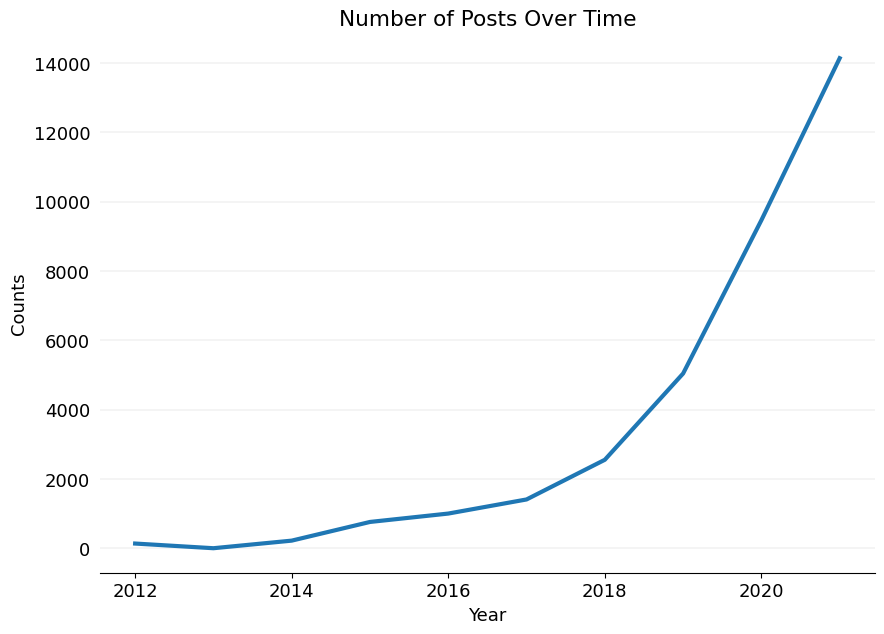

In [30]:
plt.figure(figsize=(10, 7))
ax = sns.lineplot(data=posts_year_df, x='Year', y='Counts', linewidth=3)

# add grid
ax.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)
plt.tick_params(left=False)  # remove the ticks

# Remove top, left, right border
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.title('Number of Posts Over Time')
plt.savefig(os.path.join(endo_dir, 'data', f'posts_years_lines.png'), dpi = 300, bbox_inches = "tight")
plt.show()

### Barplot

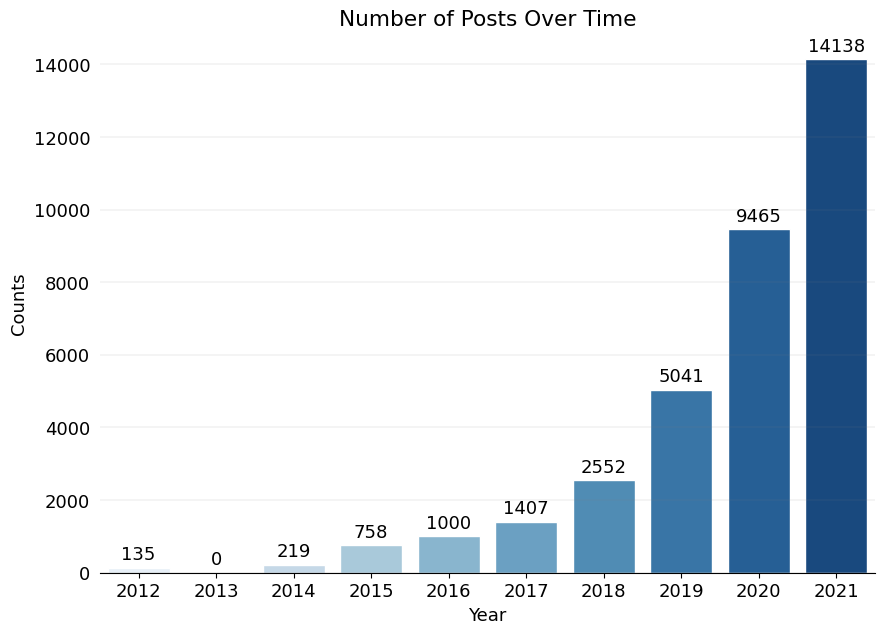

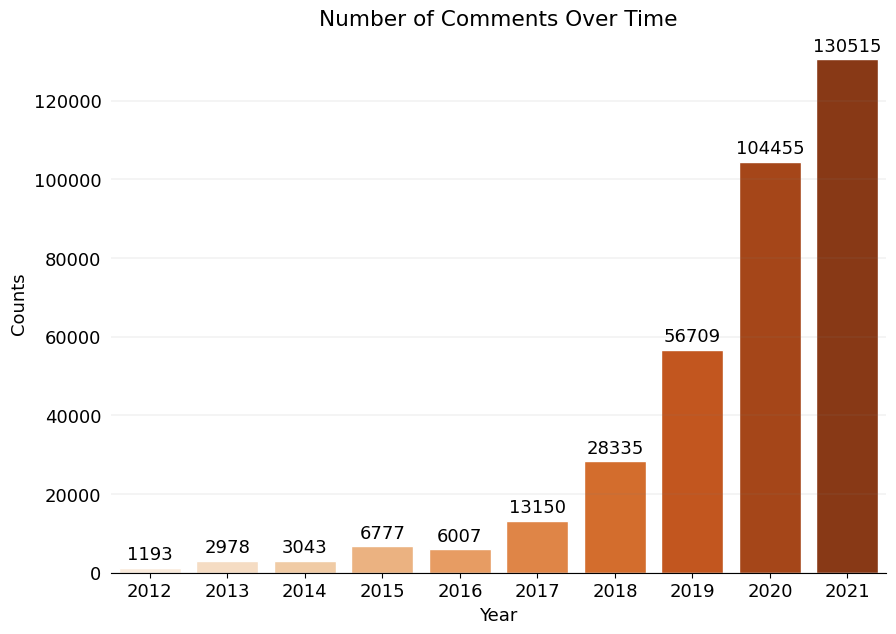

In [31]:
for tup in [('Posts', posts_year_df, "Blues"), ('Comments', comments_year_df, "Oranges")]:

  typ = tup[0]
  df = tup[1]
  color_keyword = tup[2]

  plt.figure(figsize=(10, 7))
  ax = sns.barplot(data=df, x='Year', y='Counts', hue='Year', legend=False,
                  palette=sns.color_palette(color_keyword, len(df.index)),
                  edgecolor='white',
                  errorbar=None)
  for container in ax.containers:
    for v in container:
      labels = [f'{round(v.get_height())}' for v in container]
      ax.bar_label(container, labels=labels, padding=3)

  # add grid
  ax.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)
  #plt.xticks(rotation=45, ha='right')
  plt.tick_params(left=False)  # remove the ticks

  # Remove top, left, right border
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['left'].set_visible(False)

  plt.title(f'Number of {typ} Over Time')
  plt.savefig(os.path.join(endo_dir, 'data', f'{typ.lower()}_years.png'), dpi = 300, bbox_inches = "tight")
  plt.show()

### Length

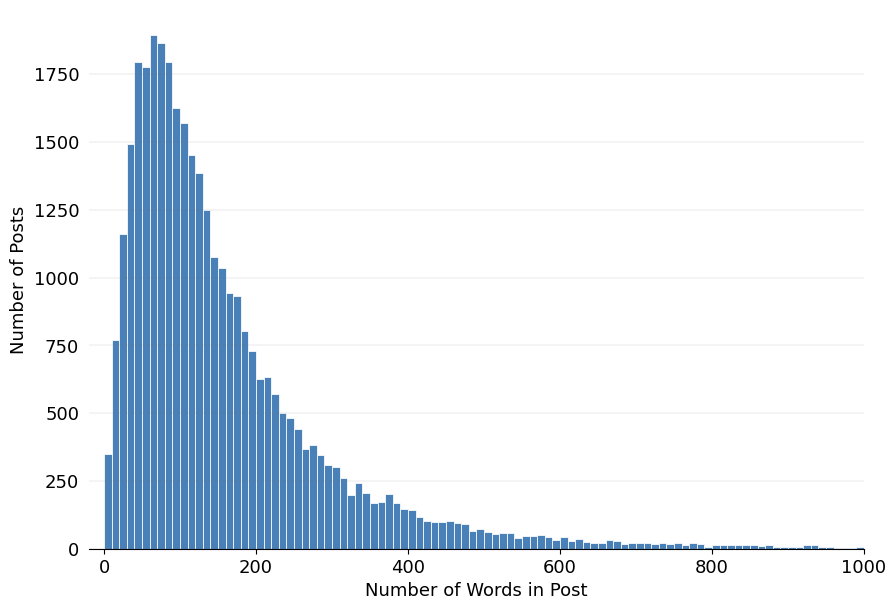

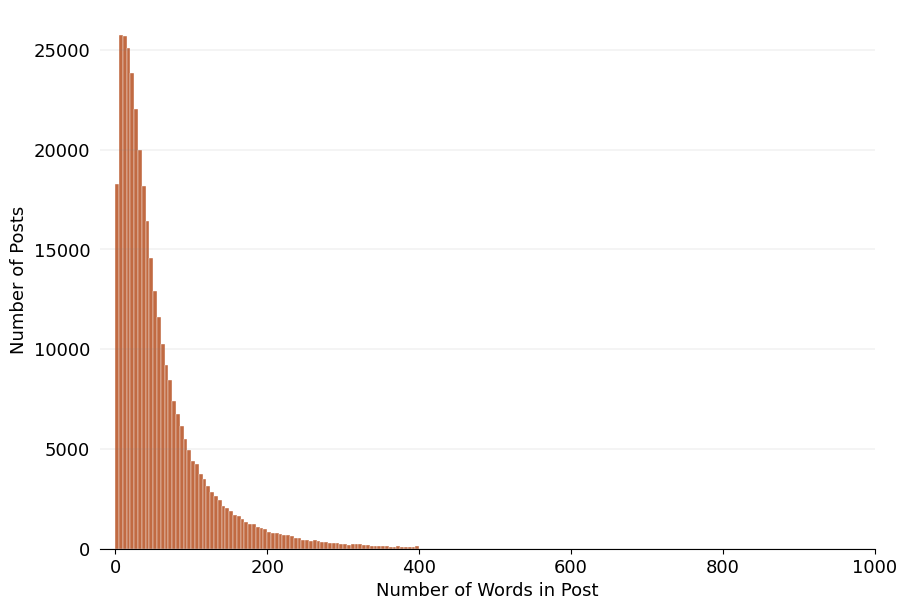

In [44]:
for tup in [('Posts', posts_year_df, "Blues"), ('Comments', comments_year_df, "Oranges")]:

  typ = tup[0]
  df = tup[1]
  color_keyword = tup[2]

  plt.figure(figsize=(10, 7))
  plt.xlim(xmin=-10,xmax=1000)

  color = sns.color_palette(color_keyword)[len(df.index)//2]
  if typ == 'Posts':
    ax = sns.histplot(data=posts, x="n_words", bins=100, binrange=(0,1000), color=color, edgecolor='white')
  elif typ == 'Comments':
    ax = sns.histplot(data=comments, x="n_words", bins=80, binrange=(0,400), color=color, edgecolor='white')

  ax.set_xlim(-20,1000)
  ax.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)
  plt.tick_params(left=False)
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['left'].set_visible(False)

  plt.xlabel('Number of Words in Post')
  plt.ylabel('Number of Posts')
  plt.savefig(os.path.join(endo_dir, 'data', f'len_{typ.lower()}.png'), dpi = 500, bbox_inches = "tight")
  plt.show()

# Other

## Common authors

In [ ]:
print(f'Common authors: {len(np.intersect1d(endo.author.unique().tolist(), endometriosis.author.unique().tolist()))}')

Common authors: 7631


## Removed posts and comments

In [ ]:
flag = 0
for index, row in data_df.loc[data_df['type']=='post'].iterrows():
  if row['text'] == '[deleted]' or row['text'] == '[removed]':
    flag+=1

flag

0

In [ ]:
flag = 0
for index, row in data_df.loc[data_df['type']=='comment'].iterrows():
  if row['text'] == '[deleted]' or row['text'] == '[removed]':
    flag+=1

flag

4210

In [ ]:
flag = 0
for index, row in data_df.loc[data_df['subreddit']=='Endo'].loc[data_df['type']=='comment'].iterrows():
  if row['text'] == '[deleted]' or row['text'] == '[removed]':
    flag+=1

flag

3002

In [ ]:
flag = 0
for index, row in data_df.loc[data_df['subreddit']=='endometriosis'].loc[data_df['type']=='comment'].iterrows():
  if row['text'] == '[deleted]' or row['text'] == '[removed]':
    flag+=1

flag

1208

## Topic modeling file

In [ ]:
#Load topic modeling file
topic_model_file = os.path.join(endo_dir, 'output', 'topic-modeling', 'parags', 'endo+endometriosis-25_10.pkl')
tomo_df = pd.read_pickle(topic_model_file).reset_index().rename(columns = {"index":"id"}) # change index into column

# add column with info about where the paragraph comes from, whether post or comment
tomo_df['og_id'] = ['_'.join(x.split('_')[:3]) for x in tomo_df.id]

# group paragraphs' distributions by the post/comment the paragraph comes from, taking the average of the distributions
type_df = tomo_df.groupby(['og_id'], sort=False).mean().reset_index().rename(columns = {"og_id":"id"}).drop(columns=['dominant_topic'])
type_df['type'] = [x.split('_')[2] for x in type_df.id]
print(len(type_df))

334042


In [ ]:
len(type_df.loc[type_df['type']=='post'])

34190

In [ ]:
len(type_df.loc[type_df['type']=='comment'])

299852